In [6]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
x_train , x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val = x_val.astype('float32')

In [10]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_val))
print(len(y_val))

40000
40000
10000
10000
10000
10000


In [11]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))

x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
x_val = (x_val-mean)/(std+1e-7)

In [12]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
y_val = np_utils.to_categorical(y_val,num_classes)

In [13]:
weight_decay = 1e-4

In [14]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
  
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [16]:
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger,ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
mc = ModelCheckpoint('Ciphar(relu)_RMS.h5', monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir='./logs', write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, update_freq='epoch')
cv = CSVLogger('Ciphar(relu)_RMS.csv',append=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [17]:
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=200,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule),mc,cv,tb,rp,es])

Epoch 1/200
625/625 [==============================] - 17s 27ms/step - loss: 1.9940 - acc: 0.4126 - val_loss: 1.7767 - val_acc: 0.4727
Epoch 2/200
625/625 [==============================] - 16s 25ms/step - loss: 1.5409 - acc: 0.5430 - val_loss: 1.6640 - val_acc: 0.5516
Epoch 3/200
625/625 [==============================] - 15s 25ms/step - loss: 1.3817 - acc: 0.5969 - val_loss: 1.2315 - val_acc: 0.6327
Epoch 4/200
625/625 [==============================] - 15s 25ms/step - loss: 1.2685 - acc: 0.6403 - val_loss: 1.1854 - val_acc: 0.6878
Epoch 5/200
625/625 [==============================] - 16s 25ms/step - loss: 1.1847 - acc: 0.6671 - val_loss: 1.0149 - val_acc: 0.7240
Epoch 6/200
625/625 [==============================] - 15s 25ms/step - loss: 1.1948 - acc: 0.6795 - val_loss: 1.0551 - val_acc: 0.7145
Epoch 7/200
625/625 [==============================] - 16s 25ms/step - loss: 1.1162 - acc: 0.6986 - val_loss: 0.9682 - val_acc: 0.7154
Epoch 8/200
625/625 [==============================] - 

625/625 [==============================] - 15s 25ms/step - loss: 0.6654 - acc: 0.8299 - val_loss: 0.7003 - val_acc: 0.8346
Epoch 62/200
625/625 [==============================] - 15s 25ms/step - loss: 0.6678 - acc: 0.8291 - val_loss: 0.7196 - val_acc: 0.8237
Epoch 63/200
625/625 [==============================] - 15s 25ms/step - loss: 0.6561 - acc: 0.8326 - val_loss: 0.6979 - val_acc: 0.8274
Epoch 64/200
625/625 [==============================] - 15s 25ms/step - loss: 0.6475 - acc: 0.8318 - val_loss: 0.6840 - val_acc: 0.8366
Epoch 65/200
625/625 [==============================] - 15s 25ms/step - loss: 0.6387 - acc: 0.8347 - val_loss: 0.7360 - val_acc: 0.8139
Epoch 66/200
625/625 [==============================] - 16s 25ms/step - loss: 0.6370 - acc: 0.8379 - val_loss: 0.6398 - val_acc: 0.8457
Epoch 67/200
625/625 [==============================] - 15s 25ms/step - loss: 0.6299 - acc: 0.8384 - val_loss: 0.6440 - val_acc: 0.8368
Epoch 68/200
625/625 [==============================] - 15s 2

625/625 [==============================] - 15s 24ms/step - loss: 0.4227 - acc: 0.8904 - val_loss: 0.4866 - val_acc: 0.8805
Epoch 122/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4236 - acc: 0.8890 - val_loss: 0.4993 - val_acc: 0.8766
Epoch 123/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4186 - acc: 0.8890 - val_loss: 0.4890 - val_acc: 0.8790
Epoch 124/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4210 - acc: 0.8881 - val_loss: 0.5128 - val_acc: 0.8727
Epoch 125/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4211 - acc: 0.8896 - val_loss: 0.5067 - val_acc: 0.8748
Epoch 126/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4150 - acc: 0.8909 - val_loss: 0.4781 - val_acc: 0.8839
Epoch 127/200
625/625 [==============================] - 15s 24ms/step - loss: 0.4114 - acc: 0.8928 - val_loss: 0.5135 - val_acc: 0.8731
Epoch 128/200
625/625 [==============================] 

Epoch 181/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3793 - acc: 0.8981 - val_loss: 0.4840 - val_acc: 0.8746
Epoch 182/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3849 - acc: 0.8978 - val_loss: 0.4985 - val_acc: 0.8757
Epoch 183/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3876 - acc: 0.8955 - val_loss: 0.4775 - val_acc: 0.8777
Epoch 184/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3811 - acc: 0.8995 - val_loss: 0.4626 - val_acc: 0.8864
Epoch 185/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3815 - acc: 0.8986 - val_loss: 0.4858 - val_acc: 0.8844
Epoch 186/200
625/625 [==============================] - 15s 24ms/step - loss: 0.3861 - acc: 0.8971 - val_loss: 0.4644 - val_acc: 0.8849
Epoch 187/200
625/625 [==============================] - 15s 23ms/step - loss: 0.3850 - acc: 0.8990 - val_loss: 0.4817 - val_acc: 0.8792
Epoch 188/200
625/625 [==================

In [18]:
test_loss,test_acc=model.evaluate(x_test,y_test)
print(test_loss)
print(test_acc)

10000/10000 [==============================] - 1s 146us/step
0.4823691347837448
0.878


In [21]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(200)

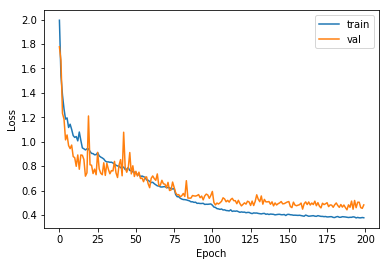

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

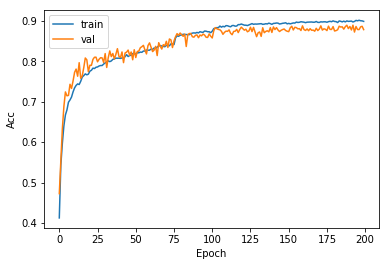

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [24]:
pred=model.predict(x_test[0].reshape(1,32,32,3))
print(pred)
print(pred.argmax())

[[4.4920199e-04 2.9189307e-03 2.0648104e-03 9.7584939e-01 3.0872212e-05
  1.9443491e-03 1.1758340e-02 3.2311571e-06 4.8238803e-03 1.5700886e-04]]
3


In [25]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.88      0.92      0.90      1000
     class 1       0.94      0.96      0.95      1000
     class 2       0.83      0.86      0.84      1000
     class 3       0.83      0.70      0.76      1000
     class 4       0.86      0.89      0.88      1000
     class 5       0.91      0.71      0.80      1000
     class 6       0.77      0.97      0.86      1000
     class 7       0.92      0.90      0.91      1000
     class 8       0.94      0.94      0.94      1000
     class 9       0.91      0.93      0.92      1000

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [26]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    acc=np.trace(cm)/float(np.sum(cm))
    miss_class=1-acc
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(acc)
    print(miss_class)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[918   6  27   2   6   1   7   4  19  10]
 [  5 957   0   0   0   0   2   0   4  32]
 [ 19   0 856  10  28  10  62   9   2   4]
 [ 16   7  47 705  38  47  98  18   8  16]
 [  6   1  29   9 891   4  42  16   1   1]
 [ 14   2  41 106  31 712  53  29   4   8]
 [  3   1  11   4   9   0 967   0   3   2]
 [ 11   1  13  13  28   7  15 903   3   6]
 [ 29  10   1   0   0   0   6   0 945   9]
 [ 17  34   4   3   2   1   0   0  13 926]]
0.878
0.122


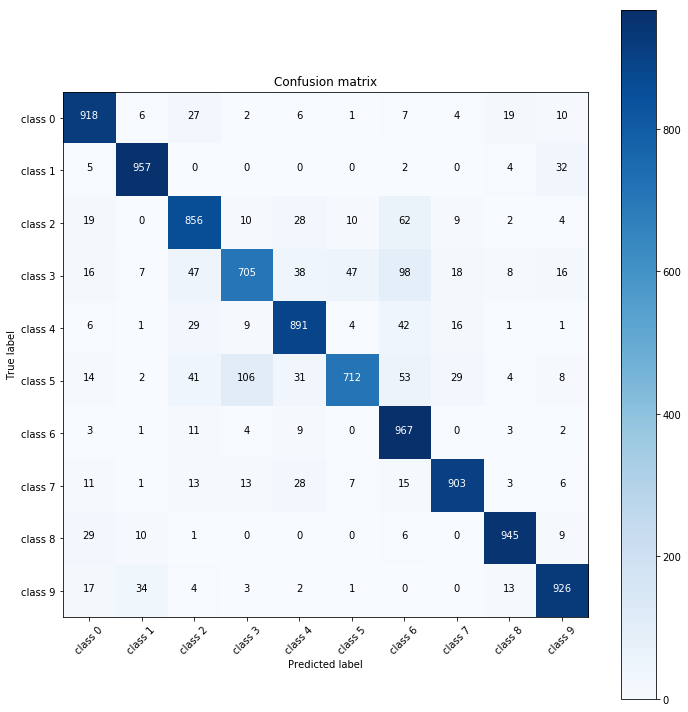

In [27]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')